**Experiment3:**


# **VGG16**:

learning rate = 0.09

dropout: 0.25

L2 Regularization: 0.09

# **LSTM**:

units: 32

learning rate = 0.09

dropout: 0.25

optimizer: 0.09


# **Lightgbm**:

learning rate: 0.9

Estimators:120

max depth: 6

child:60

feature:0.5

bagging: 0.6

Mounting to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import important libraries

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.signal
import glob
import os
import seaborn as sns
%matplotlib inline

In [ ]:
# Getting the ECG signals from original files
# data path in drive:
from google.colab import drive
drive.mount('/content/drive')
general_directory = os.path.join(os.getcwd(), '/content/drive/MyDrive/RECOGNITION OF THE HUMANN ICGID /ecg-id-database-1.0.0/')
entries = os.listdir(general_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
entries

['Person_06',
 'Person_05',
 'Person_03',
 'Person_01',
 'Person_07',
 'Person_02',
 'Person_08',
 'Person_04',
 'Person_16',
 'Person_09',
 'Person_17',
 'Person_18',
 'Person_11',
 'Person_10',
 'Person_13',
 'Person_15',
 'Person_14',
 'Person_12',
 'Person_25',
 'Person_22',
 'Person_20',
 'Person_19',
 'Person_23',
 'Person_24',
 'Person_28',
 'Person_26',
 'Person_27',
 'Person_21',
 'Person_32',
 'Person_30',
 'Person_31',
 'Person_29',
 'Person_38',
 'Person_36',
 'Person_37',
 'Person_33',
 'Person_34',
 'Person_35',
 'Person_44',
 'Person_47',
 'Person_46',
 'Person_41',
 'Person_39',
 'Person_43',
 'Person_42',
 'Person_45',
 'Person_48',
 'Person_40',
 'Person_49',
 'Person_50',
 'Person_54',
 'Person_55',
 'Person_58',
 'Person_56',
 'Person_53',
 'Person_51',
 'Person_57',
 'Person_52',
 'Person_59',
 'Person_64',
 'Person_66',
 'Person_62',
 'Person_65',
 'Person_67',
 'Person_63',
 'Person_68',
 'Person_60',
 'Person_61',
 'Person_77',
 'Person_70',
 'Person_73',
 'Pers

In [ ]:
# install wfdb to read the signals
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import wfdb
fs = 500 # Sampling frequency indicated by the publisher of the database
subject, age, gender, RR, ecg_mean, ecg_std, ecg_var, ecg_median, ecg_samples , signals = [], [], [], [], [], [], [], [], [], []

for folder in entries:
    if "Person_" in folder:
        info_targetPattern = os.path.join(general_directory, folder, '*.hea')
        info_files = glob.glob(info_targetPattern)

        for ecg_info in info_files:
            with open(ecg_info) as f:
                subject_info = int(folder.replace("Person_","", 1))
                signal, _ = wfdb.rdsamp(ecg_info[:-4])
                signal = signal[:, 0]
                # Extracting demographic information
                lines = [line.rstrip() for line in f]
                age_info = int([int(s) for s in lines[4].split() if s.isdigit()][0])
                condition = lines[5].find('female')
                gender_info = 'female' if condition > 0 else 'male'

                ecg_signal_file = ecg_info.replace(".hea", ".dat")
                ecg_signal = np.fromfile(ecg_signal_file, dtype='int32')
                ecg_signal = ecg_signal/max(ecg_signal)
                ts = np.arange(0, len(ecg_signal)/fs, 1/fs)

                # RR intervals calculation
                pks_RR = sp.signal.find_peaks(ecg_signal, height=np.mean(np.abs(ecg_signal)*5), distance=500)[0]
                RR_samples = np.diff(pks_RR)
                RR_time = RR_samples*ts[1]

                # Filling row gaps with blank spaces
                if len(pks_RR) <= 1:
                    subject.append(subject_info)
                    age.append(age_info)
                    gender.append(gender_info)
                    signals.append(signal)
                    ecg_mean.append('')
                    ecg_std.append('')
                    ecg_var.append('')
                    ecg_median.append('')
                    RR.append('')
                    ecg_samples.append('')

                # Assigning values to the correspondent row
                for index in range(len(pks_RR)-1):

                    subject.append(subject_info)
                    age.append(age_info)
                    gender.append(gender_info)
                    signals.append(signal)
                    ecg_mean.append(np.mean(ecg_signal[pks_RR[index]:pks_RR[index+1]]))
                    ecg_std.append(np.std(ecg_signal[pks_RR[index]:pks_RR[index+1]]))
                    ecg_var.append(np.var(ecg_signal[pks_RR[index]:pks_RR[index+1]]))
                    ecg_median.append(np.median(ecg_signal[pks_RR[index]:pks_RR[index+1]]))
                    RR.append(RR_time[index])
                    ecg_samples.append(ecg_signal[pks_RR[index]:pks_RR[index+1]])

In [ ]:
# create a DataFrame to save all the data information in columns

data={"Subject_ID": subject, "Age": np.array(age), "Gender": gender, "RR": RR, "ECG_mean": ecg_mean, "ECG_std": ecg_std,
      "ECG_var": ecg_var, "ECG_median": ecg_median, "Signals": signals}
df_ecg = pd.DataFrame(data)
df_ecg

,Subject_ID,Age,Gender,RR,ECG_mean,ECG_std,ECG_var,ECG_median,Signals
0,6,21,female,2.876,0.014965,0.238664,0.056961,-0.05715,"[-0.27, -0.165, -0.13, -0.16, -0.155, -0.135, ..."
1,6,21,female,9.358,0.015806,0.218482,0.047734,-0.05715,"[-0.27, -0.165, -0.13, -0.16, -0.155, -0.135, ..."
2,6,21,female,1.816,0.012776,0.232558,0.054083,-0.042875,"[-0.27, -0.165, -0.13, -0.16, -0.155, -0.135, ..."
3,6,21,female,1.504,0.011876,0.251055,0.063029,-0.075023,"[-0.805, -0.74, -0.83, -0.84, -0.87, -0.965, -..."
4,6,21,female,1.34,0.012141,0.251706,0.063356,-0.075024,"[-0.805, -0.74, -0.83, -0.84, -0.87, -0.965, -..."
...,...,...,...,...,...,...,...,...,...
2861,89,40,female,1.848,0.007995,0.136229,0.018558,-0.039757,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1..."
2862,89,40,female,2.784,0.007042,0.13518,0.018274,-0.034091,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1..."
2863,89,40,female,2.79,0.003459,0.12851,0.016515,-0.039772,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1..."
2864,89,40,female,1.712,0.003983,0.133123,0.017722,-0.039772,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1..."


Preprocessing

In [ ]:
# DataFrame description

num_rows = df_ecg.shape[0] #Provide the number of rows in the dataset
num_cols = df_ecg.shape[1] #Provide the number of columns in the dataset

print(num_rows, num_cols)
df_ecg.describe()

2866 9


,Subject_ID,Age
count,2866.000000,2866.000000
mean,38.960223,28.826239
std,26.467956,11.866645
min,1.000000,13.000000
25%,13.000000,21.000000
50%,39.000000,23.000000
75%,61.000000,34.000000
max,90.000000,75.000000


In [ ]:
# Checking categorical columns of the DataFrame

print(df_ecg.dtypes)

cat_df = df_ecg.select_dtypes(include=["object"])
cat_df.shape[1]
cat_df.isnull().sum().sort_values()

Subject_ID     int64
Age            int64
Gender        object
RR            object
ECG_mean      object
ECG_std       object
ECG_var       object
ECG_median    object
Signals       object
dtype: object


Gender        0
RR            0
ECG_mean      0
ECG_std       0
ECG_var       0
ECG_median    0
Signals       0
dtype: int64

In [ ]:

# Replacing blank spaces with NaN, resulting in numerical columns instead of categorical type

df_ecg["RR"] = df_ecg["RR"].replace("", np.nan)
df_ecg["ECG_mean"] = df_ecg["ECG_mean"].replace("", np.nan)
df_ecg["ECG_std"] = df_ecg["ECG_std"].replace("", np.nan)
df_ecg["ECG_var"] = df_ecg["ECG_var"].replace("", np.nan)
df_ecg["ECG_median"] = df_ecg["ECG_median"].replace("", np.nan)

df_ecg.dtypes

Subject_ID      int64
Age             int64
Gender         object
RR            float64
ECG_mean      float64
ECG_std       float64
ECG_var       float64
ECG_median    float64
Signals        object
dtype: object

In [ ]:
df_ecg.describe()

,Subject_ID,Age,RR,ECG_mean,ECG_std,ECG_var,ECG_median
count,2866.000000,2866.000000,2839.000000,2839.000000,2839.000000,2839.000000,2839.000000
mean,38.960223,28.826239,1.773335,0.003876,0.173830,0.031876,-0.043297
std,26.467956,11.866645,0.822360,0.009398,0.040738,0.017190,0.019161
min,1.000000,13.000000,1.000000,-0.131275,0.074087,0.005489,-0.153844
25%,13.000000,21.000000,1.380000,0.000495,0.147340,0.021709,-0.053634
50%,39.000000,23.000000,1.628000,0.003813,0.162493,0.026404,-0.043322
75%,61.000000,34.000000,1.959000,0.006999,0.196156,0.038477,-0.032924
max,90.000000,75.000000,13.722000,0.153532,0.567605,0.322175,0.095204


In [ ]:
no_nulls = set(df_ecg.dropna(axis="columns").columns) # Provide a set of columns with 0 missing values.
print(no_nulls)
most_missing_cols = set(df_ecg.columns[df_ecg.isnull().sum() > len(df_ecg)*0.05]) # Provide a set of columns with more than 5% of the values missing
print(most_missing_cols)

{'Age', 'Gender', 'Subject_ID', 'Signals'}
set()


In [ ]:
# df_ecg.to_pickle("df_ecg")

# df_ecg_samples = pd.DataFrame(ecg_samples).add_prefix('ecg_')
# df_ecg_samples.to_pickle("df_ecg_samples")

EDA

<ipython-input-13-e3e563863453>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


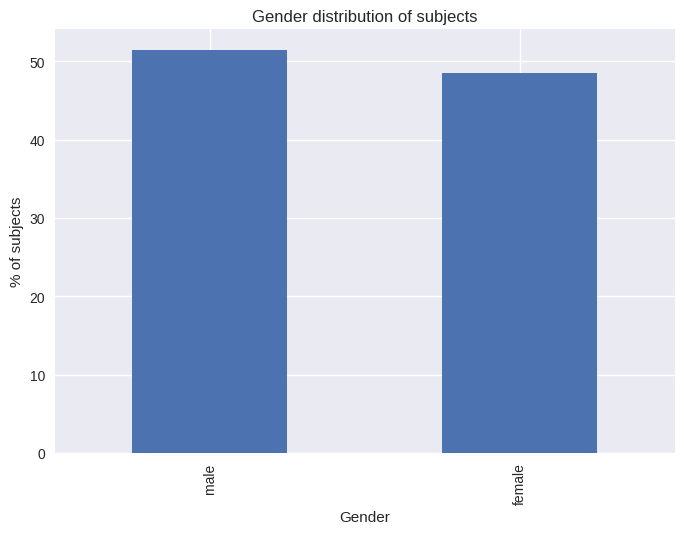

In [ ]:
# Gender distribution
plt.style.use("seaborn")

gender_vals = pd.Series(data=df_ecg["Gender"].value_counts())
((gender_vals/df_ecg.shape[0])*100).plot(kind='bar')
plt.title("Gender distribution of subjects")
plt.xlabel("Gender")
plt.ylabel("% of subjects");

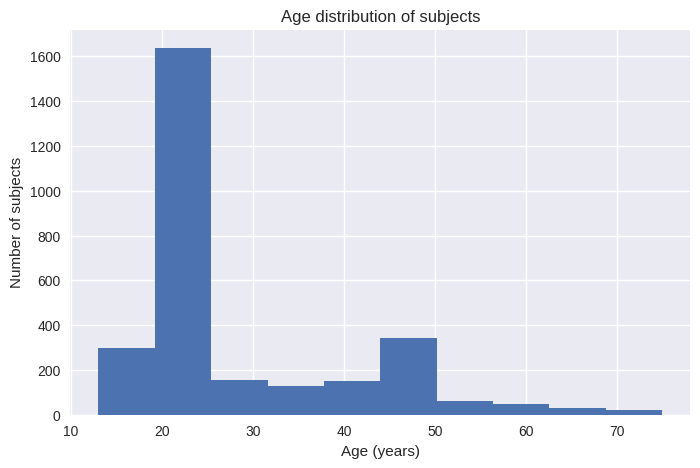

In [ ]:
# Age distribution
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(df_ecg["Age"]);
ax.set(title="Age distribution of subjects",
      xlabel="Age (years)",
      ylabel="Number of subjects");

**Normalization Step**


Normalization is a pre-processing stage of any type of problem statement. In particular, normalization takes an important role in the field of soft computing, cloud computing, etc. for manipulation of data, scaling down, or scaling up the range of data before it becomes used for further stages. There are so many normalization techniques there, namely Min-Max normalization, Z-score normalization, and Decimal scaling normalization.

Normalization is scaling the data to be analyzed to a specific range such as [0.0, 1.0] to provide better results.

In [ ]:
# Apply MinMax scalar:
for i, row in df_ecg.iterrows():
  row['Signals'][i] = row['Signals'][i]/np.max(row['Signals'][i])

<ipython-input-15-8476e46411f4>:3: RuntimeWarning: invalid value encountered in double_scalars
  row['Signals'][i] = row['Signals'][i]/np.max(row['Signals'][i])


In [ ]:
df_ecg['Signals'][100]

array([ 0.265,  0.25 ,  0.23 , ..., -0.18 , -0.1  , -0.08 ])

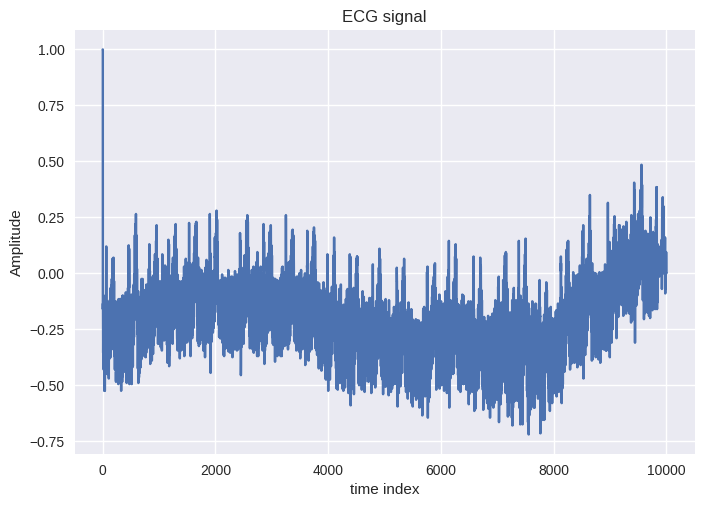

In [ ]:
plt.plot(df_ecg['Signals'][2])
plt.title("ECG signal")
plt.xlabel('time index')
plt.ylabel('Amplitude')
plt.show()

**Noise removal step:**

we will remove noise from this database by using discrete wavelet transform. The outputs are A and D the reconstruction wavelet coefficients

A: The approximation output which is the low frequency content of the input signal component.

D: The multidimensional output which gives the details, or the high frequency components, of the input signal at various levels

In [ ]:
import pywt
A, D = pywt.dwt(signals, wavelet= 'db1', mode='symmetric') #Daubechies (db) wavelet


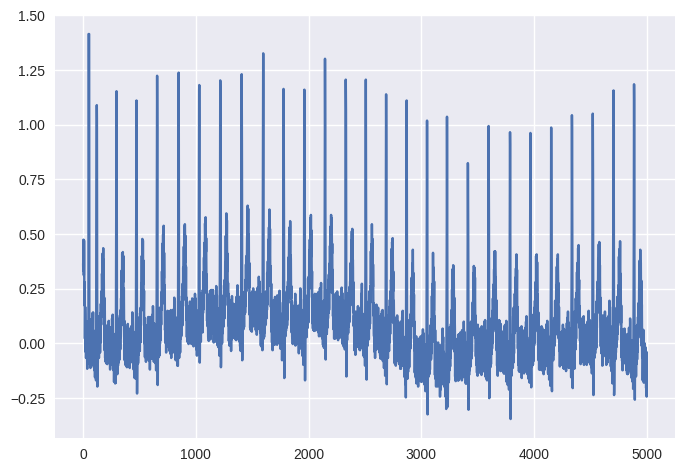

In [ ]:
plt.plot(A[100])
plt.show()

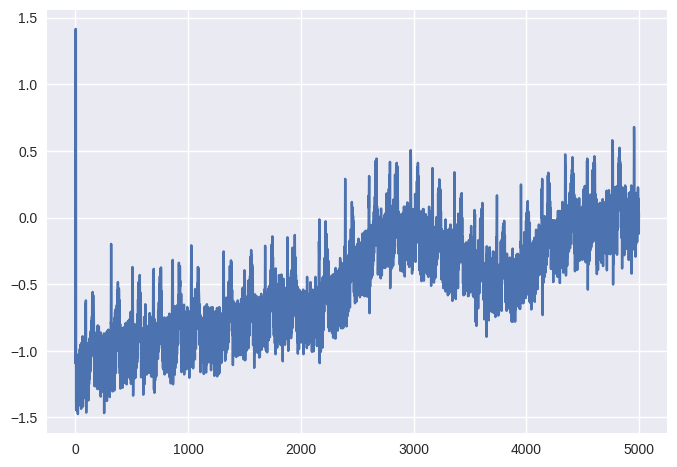

In [ ]:
plt.plot(A[5])
plt.show()

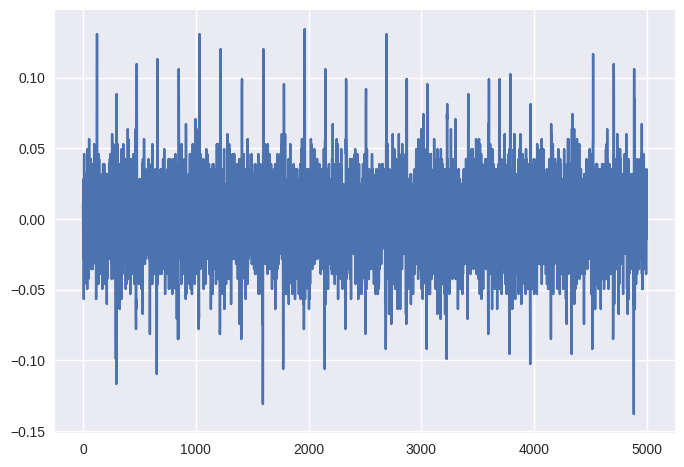

In [ ]:
plt.plot(D[100])
plt.show()

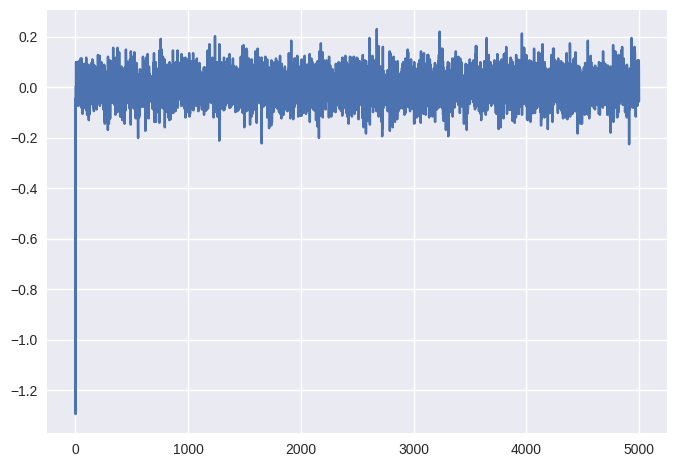

In [ ]:
plt.plot(D[5])
plt.show()

**Signal transformation using (STFT)**

apply Signal transformation using Short-time Fourier

Librosa is a Python package for music and audio analysis. Librosa is basically used when we work with audio data like in music generation(using LSTM’s), Automatic Speech Recognition.

It provides the building blocks necessary to create the music information retrieval systems. Librosa helps to visualize the audio signals and also do the feature extractions in it using different signal processing techniques.

In [ ]:
!pip install librosa

In [ ]:
#Remove the nan values from D and replace them with zeros
for s in D:
   s[np.isnan(s)] = 0
   s[np.isinf(s)] = np.finfo(np.float32).max

The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows

In [ ]:
import librosa
import numpy as np
label =[]
hop_length = 512
n_fft = 2048
S=[]
for i in range(len(D)):
  stft = librosa.stft(D[i], n_fft=n_fft, hop_length=hop_length)
  S.append(stft)
label = df_ecg['Subject_ID']

In [ ]:
label

0        6
1        6
2        6
3        6
4        6
        ..
2861    89
2862    89
2863    89
2864    89
2865    89
Name: Subject_ID, Length: 2866, dtype: int64

<ipython-input-27-5553e97575f2>:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(S[77],


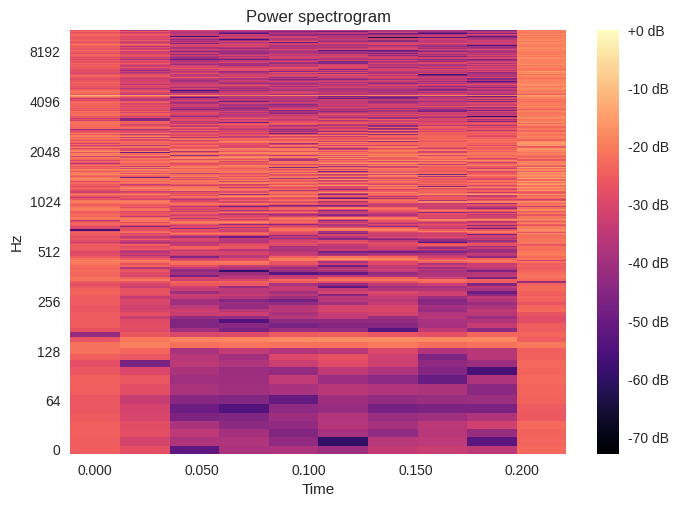

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S[77],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

<ipython-input-28-f658ea2291b3>:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(S[7],


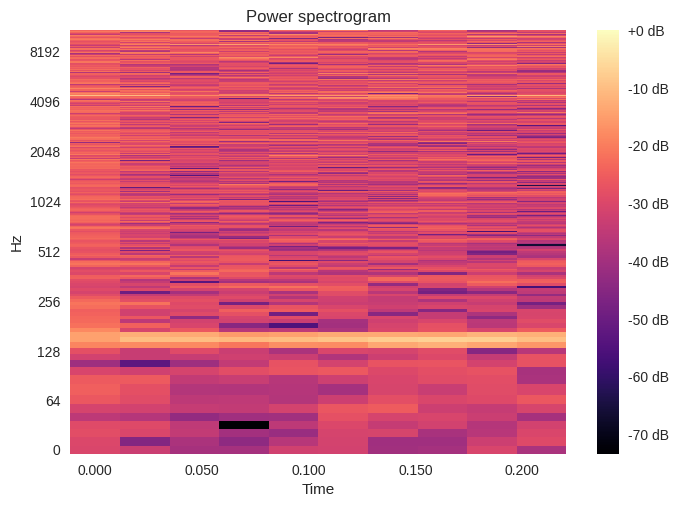

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S[7],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

# Feature Extraction
Feature extraction reduces the number of features in a dataset by creating a new set of features whose length is shorter than the initial one. We do feature extraction in this dataset to obtain the most important feature on it that affects more on the result.

In [ ]:
def preprocess_spec(spec):

# Reshape signal to 2D array with 1 channel
   x = librosa.amplitude_to_db(spec,ref=np.max)

# Rescale signal values to 0-255 range
   x = cv2.normalize(x, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

# Reshape signal to 2D image with appropriate dimensions
   height, width = 224, 224 # choose desired image size
   image = cv2.resize(x, (height, width), interpolation=cv2.INTER_AREA)

# Stack 2D image into 3 channels for DenseNet model input
   image = np.stack([image] * 3, axis=-1)

# Normalize image values to range [-1, 1] as expected by DenseNet
   image = image / 127.5 - 1

# Feed image into DenseNet model for inference
   return np.array([image])


to do this, we applied DenseNet feature extractor then predict and append the features

In [ ]:
# import wfdb
# import numpy as np
# import cv2
# from sklearn.model_selection import train_test_split
# from keras.applications.densenet import DenseNet121
# from keras.models import Model
# from keras.layers import GlobalAveragePooling2D, Input
# # Extract features using the DenseNet model
# input_shape = (224, 224, 3)
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# denseM = Model(inputs=base_model.input, outputs=x)
# features = []
# y = []
# for i in range(len(S)):
#   image = preprocess_spec(S[i])
#   result = image[0, :, :]
#   feature = denseM.predict(np.array([result]))[0]
#   features.append(feature)
#   y.append(label[i])

VGG16

In [ ]:
import wfdb
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Dropout, Dense
from keras.optimizers import Adam
from keras.regularizers import L2
# Define hyperparameters
learning_rate = 0.09
dropout_rate = 0.25
regularization_rate = 0.09

# Extract features using the VGG16 model
input_shape = (224, 224, 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(dropout_rate)(x) # Add dropout layer
x = Dense(1, activation='sigmoid', kernel_regularizer=L2(regularization_rate))(x)
VGG16 = Model(inputs=base_model.input, outputs=x)

features1 = []
y = []

for i in range(len(S)):
    image = preprocess_spec(S[i])
    result = image[0, :, :]
    feature = VGG16.predict(np.array([result]))[0]
    features1.append(feature)
    y.append(label[i])



58889256/58889256 [==============================] - 0s 0us/step


<ipython-input-29-bb0fbcb6dd7b>:4: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  x = librosa.amplitude_to_db(spec,ref=np.max)


1/1 [==============================] - 0s 34ms/step


VGG19:

In [ ]:

# import wfdb
# import numpy as np
# import cv2
# from sklearn.model_selection import train_test_split
# from keras.applications.vgg19 import VGG19
# from keras.models import Model
# from keras.layers import GlobalAveragePooling2D, Input

# # Extract features using the VGG19 model
# input_shape = (224, 224, 3)
# base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# VGG19 = Model(inputs=base_model.input, outputs=x)

# features2 = []
# y = []

# for i in range(len(S)):
#     image = preprocess_spec(S[i])
#     result = image[0, :, :]
#     feature = VGG19.predict(np.array([result]))[0]
#     features2.append(feature)
#     y.append(label[i])


InceptionV3:

In [ ]:

# import wfdb
# import numpy as np
# import cv2
# from sklearn.model_selection import train_test_split
# from keras.applications.inception_v3 import InceptionV3
# from keras.models import Model
# from keras.layers import GlobalAveragePooling2D, Input

# # Extract features using the InceptionV3 model
# input_shape = (224, 224, 3)
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# InceptionV3 = Model(inputs=base_model.input, outputs=x)

# features3 = []
# y = []

# for i in range(len(S)):
#     image = preprocess_spec(S[i])
#     result = image[0, :, :]
#     feature = InceptionV3.predict(np.array([result]))[0]
#     features3.append(feature)
#     y.append(label[i])




**LSTM**


Features Optimiztion usin LSTM

To prepare a list of features for use as input to an LSTM model:

In [ ]:


features1 = np.array(features1)
opt_fet = features1.reshape(len(features1), features1.shape[1], 1)
opt_fet.shape


(2866, 1, 1)

In [ ]:

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM ,Dropout
 #input shape =(1024,1)
# Define hyperparameters
learning_rate = 0.09
dropout_rate = 0.25


# Define the LSTM model
model2 = Sequential()
model2.add(LSTM(32, input_shape=(opt_fet.shape[1], opt_fet.shape[2])))
model2.add(Dropout(dropout_rate))
model2.add(Dense(90, activation='softmax'))


optimizer =  Adam(lr=learning_rate)
model2.compile(
                loss = 'categorical_crossentropy',
                optimizer = optimizer,
                metrics = ['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
opt = []

for i in range(len(opt_fet)):

  new_feature = model2.predict(np.array([opt_fet[i]]))[0]
  opt.append(new_feature)


1/1 [==============================] - 0s 22ms/step


In [ ]:
len(opt)

2866

In [ ]:
df_ecg

,Subject_ID,Age,Gender,RR,ECG_mean,ECG_std,ECG_var,ECG_median,Signals
0,6,21,female,2.876,0.014965,0.238664,0.056961,-0.057150,"[1.0, 1.0, 1.0, -0.16, -0.155, -0.135, -0.245,..."
1,6,21,female,9.358,0.015806,0.218482,0.047734,-0.057150,"[1.0, 1.0, 1.0, -0.16, -0.155, -0.135, -0.245,..."
2,6,21,female,1.816,0.012776,0.232558,0.054083,-0.042875,"[1.0, 1.0, 1.0, -0.16, -0.155, -0.135, -0.245,..."
3,6,21,female,1.504,0.011876,0.251055,0.063029,-0.075023,"[-0.805, -0.74, -0.83, 1.0, 1.0, 1.0, 1.0, 1.0..."
4,6,21,female,1.340,0.012141,0.251706,0.063356,-0.075024,"[-0.805, -0.74, -0.83, 1.0, 1.0, 1.0, 1.0, 1.0..."
...,...,...,...,...,...,...,...,...,...
2861,89,40,female,1.848,0.007995,0.136229,0.018558,-0.039757,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1..."
2862,89,40,female,2.784,0.007042,0.135180,0.018274,-0.034091,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1..."
2863,89,40,female,2.790,0.003459,0.128510,0.016515,-0.039772,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1..."
2864,89,40,female,1.712,0.003983,0.133123,0.017722,-0.039772,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1..."


In [ ]:
df_ecg['opt_features'] = opt

In [ ]:
df_ecg

,Subject_ID,Age,Gender,RR,ECG_mean,ECG_std,ECG_var,ECG_median,Signals,opt_features
0,6,21,female,2.876,0.014965,0.238664,0.056961,-0.057150,"[1.0, 1.0, 1.0, -0.16, -0.155, -0.135, -0.245,...","[0.011042972, 0.011141304, 0.011031112, 0.0111..."
1,6,21,female,9.358,0.015806,0.218482,0.047734,-0.057150,"[1.0, 1.0, 1.0, -0.16, -0.155, -0.135, -0.245,...","[0.011042972, 0.011141304, 0.011031112, 0.0111..."
2,6,21,female,1.816,0.012776,0.232558,0.054083,-0.042875,"[1.0, 1.0, 1.0, -0.16, -0.155, -0.135, -0.245,...","[0.011042972, 0.011141304, 0.011031112, 0.0111..."
3,6,21,female,1.504,0.011876,0.251055,0.063029,-0.075023,"[-0.805, -0.74, -0.83, 1.0, 1.0, 1.0, 1.0, 1.0...","[0.011042374, 0.011141579, 0.011030388, 0.0111..."
4,6,21,female,1.340,0.012141,0.251706,0.063356,-0.075024,"[-0.805, -0.74, -0.83, 1.0, 1.0, 1.0, 1.0, 1.0...","[0.011042374, 0.011141579, 0.011030388, 0.0111..."
...,...,...,...,...,...,...,...,...,...,...
2861,89,40,female,1.848,0.007995,0.136229,0.018558,-0.039757,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1...","[0.011040193, 0.011142578, 0.011027741, 0.0111..."
2862,89,40,female,2.784,0.007042,0.135180,0.018274,-0.034091,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1...","[0.011040193, 0.011142578, 0.011027741, 0.0111..."
2863,89,40,female,2.790,0.003459,0.128510,0.016515,-0.039772,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1...","[0.011040193, 0.011142578, 0.011027741, 0.0111..."
2864,89,40,female,1.712,0.003983,0.133123,0.017722,-0.039772,"[0.945, 0.44, -0.26, -0.92, -0.65, -0.25, -0.1...","[0.011040193, 0.011142578, 0.011027741, 0.0111..."


LightGBM model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(opt, label, test_size = 0.2,
                                                        )

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb

# Convert the training and testing data into LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
# Train a LightGBM model on the training set
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'multiclass',
#     'num_class': 90,
#     'metric': 'multi_logloss',
#     'num_leaves': 13,
#     'learning_rate': 0.09,
#     'feature_fraction': 0.7
# }


params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 90,
    'metric': 'multi_logloss',
    'num_leaves': 50,
    'learning_rate': 0.9,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.6,
    'estimators': 120,
    'min_child_sample': 60,
    'max_depth': 6
}

# Create an instance of the LGBMClassifier class
model = lgb.LGBMClassifier(**params)

# Train the LightGBM model on the training data
model.fit(X_train, y_train)


# Make predictions on the testing data
y_pred = model.predict(X_test)
# Evaluate the performance of the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average= 'weighted'))
print('Recall:', recall_score(y_test, y_pred, average= 'weighted'))
print('F1-score:', f1_score(y_test, y_pred,average= 'weighted'))


[LightGBM] [Warning] Unknown parameter: min_child_sample
[LightGBM] [Warning] Unknown parameter: estimators
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
Accuracy: 0.078397212543554
Precision: 0.054986796755377494
Recall: 0.078397212543554
F1-score: 0.04467773557230475


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Training accuracy {:.4f}'.format(model.score(X_train, y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.0951
Testing accuracy 0.0679


 10-fold cross validation test :

In [ ]:

from sklearn.model_selection import cross_val_score
import numpy as np

# Convert the data into LightGBM Dataset format
data = lgb.Dataset(opt, label=label)

# Create an instance of the LGBMClassifier class
model = lgb.LGBMClassifier(**params)

# Perform 10-fold cross-validation
scores = cross_val_score(model,opt, label, cv=10, scoring='accuracy')



[LightGBM] [Warning] Unknown parameter: min_child_sample
[LightGBM] [Warning] Unknown parameter: estimators
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: min_child_sample
[LightGBM] [Warning] Unknown parameter: estimators
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] Unknown parameter: min_child_sample
[LightGBM] [Warning] Unknown parameter: estimators
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] Unknown parameter: min_child_sample
[LightGBM] [Warning] Unknown parameter: estimators
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will b

In [ ]:
# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("max accuracy:", max(scores))

Cross-validation scores: [0.00348432 0.01045296 0.04181185 0.01045296 0.09059233 0.02787456
 0.03146853 0.06993007 0.02097902 0.04545455]
max accuracy: 0.09059233449477352


In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

1401.9268292682927

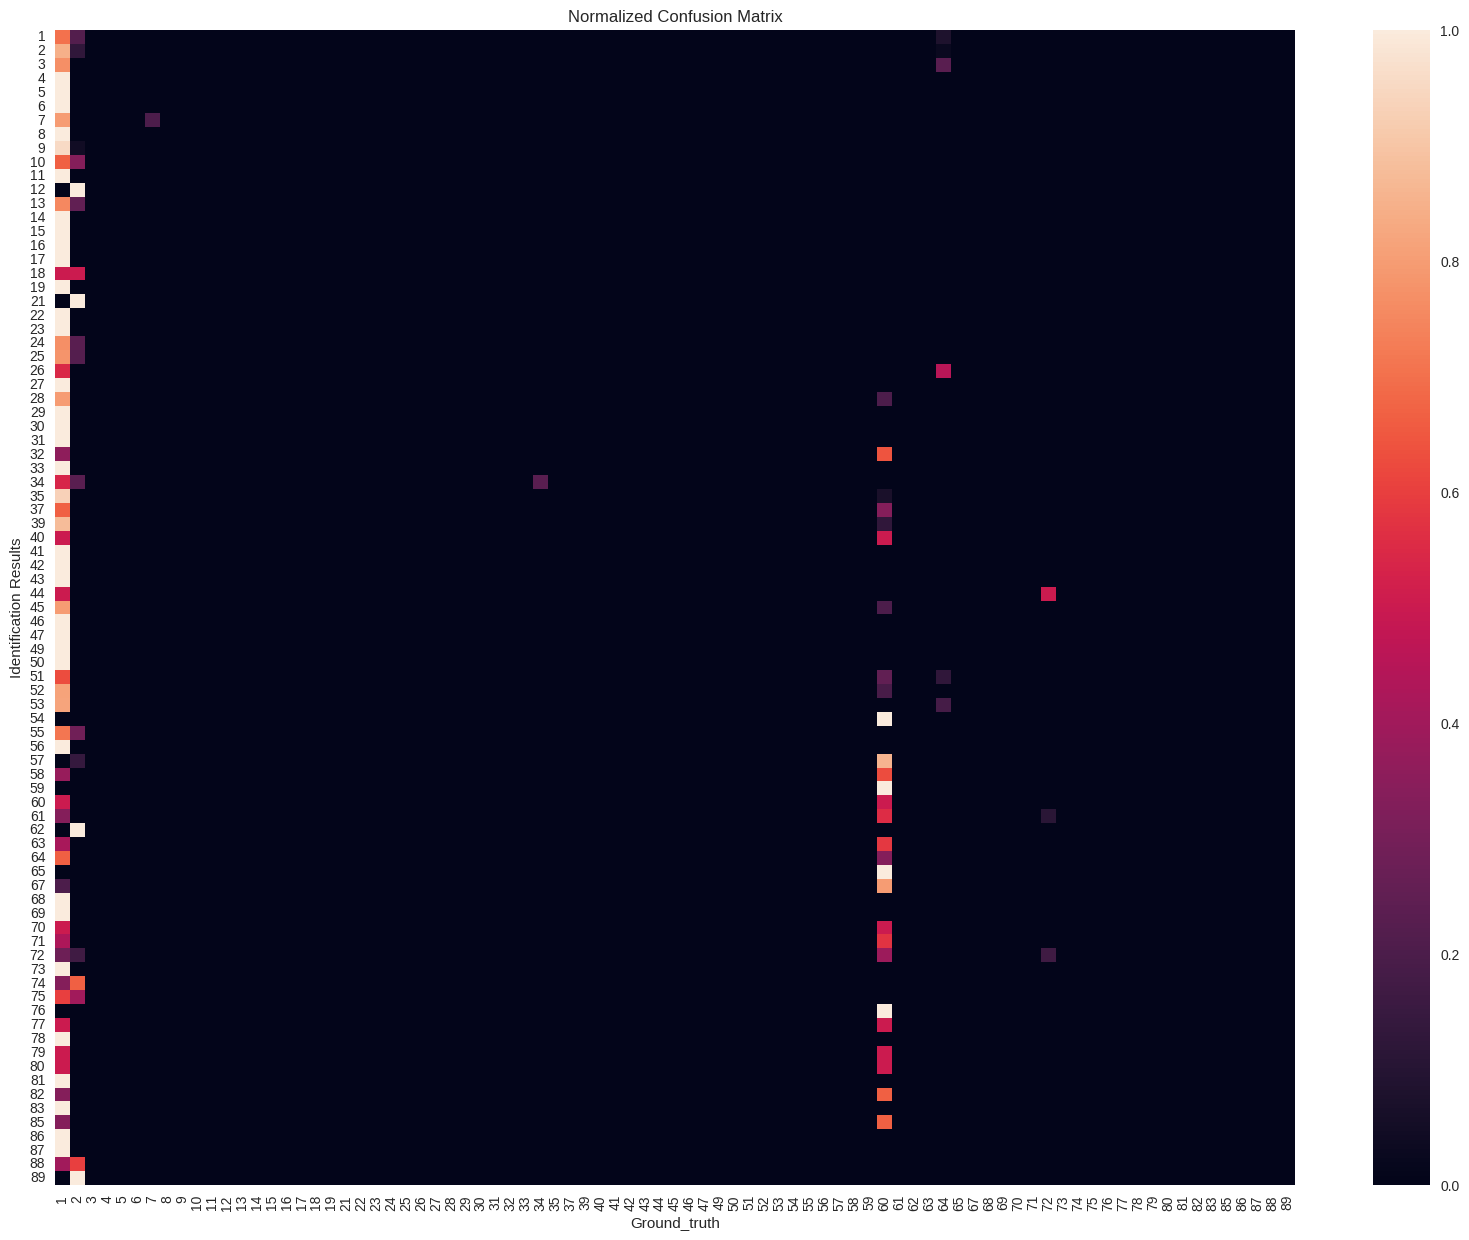

In [ ]:
# denseNet:

from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Ground_truth')
plt.ylabel('Identification Results')
plt.show()

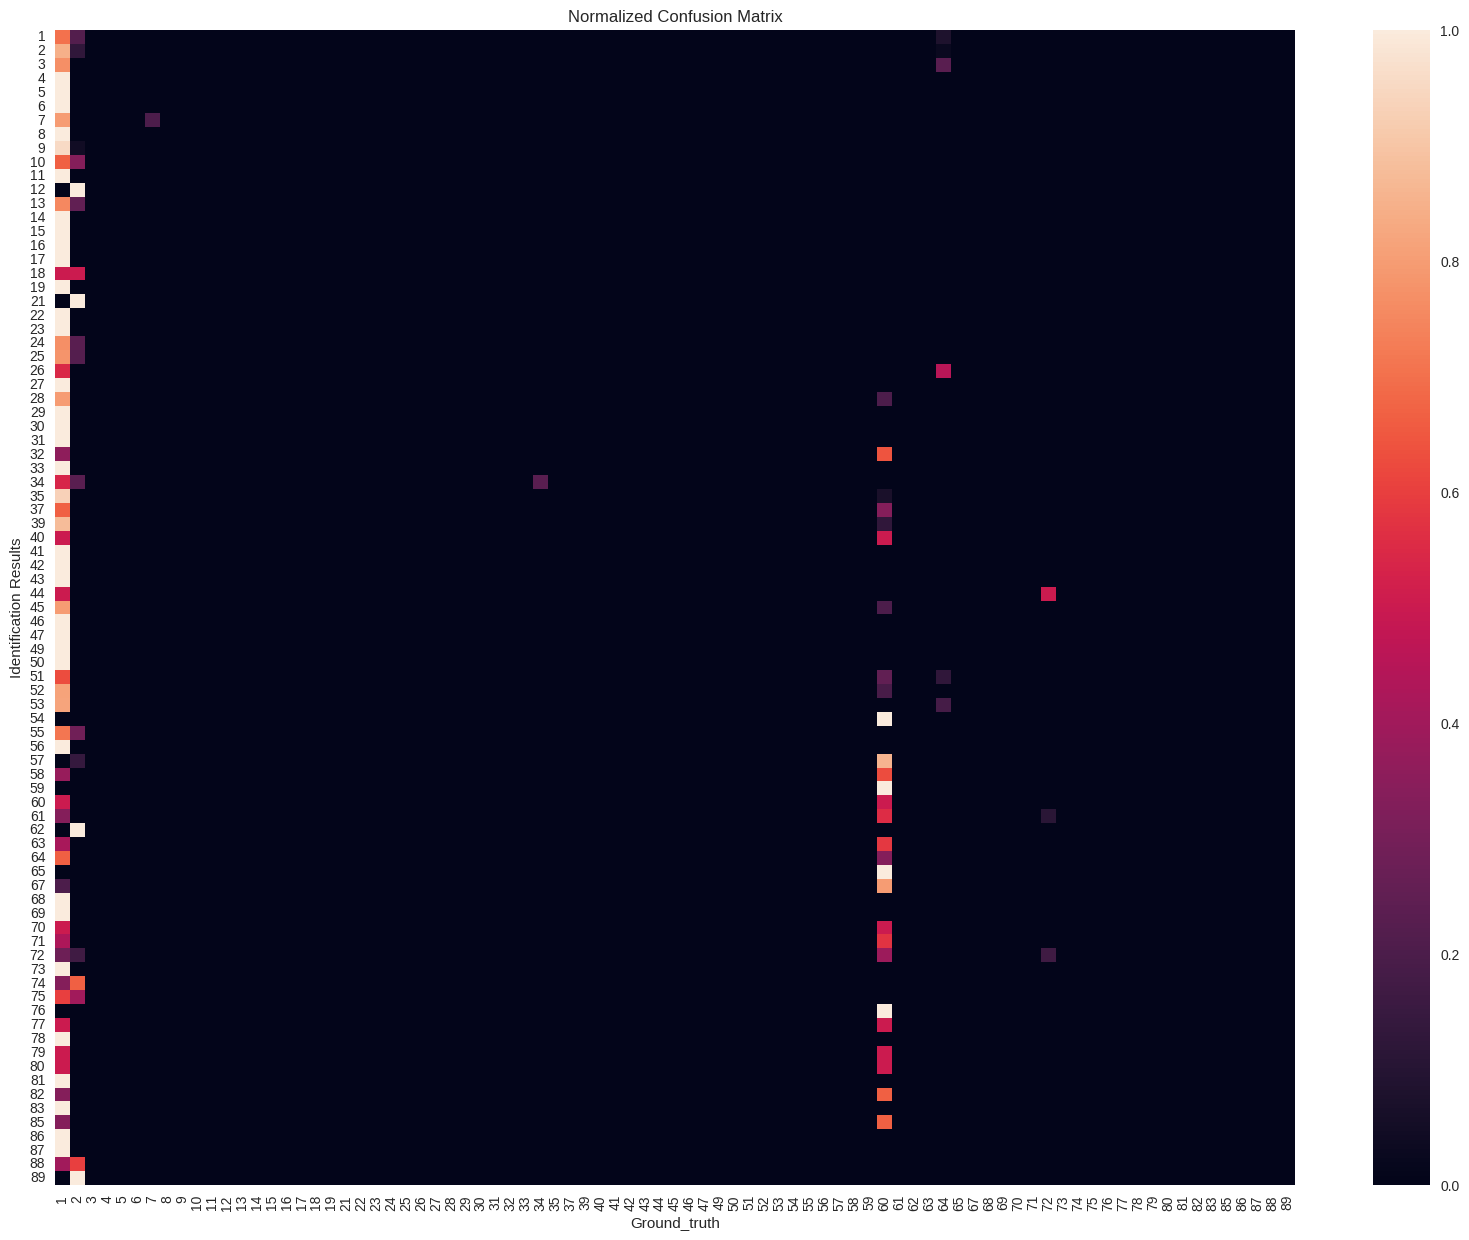

In [ ]:
# vgg16:


from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Ground_truth')
plt.ylabel('Identification Results')
plt.show()


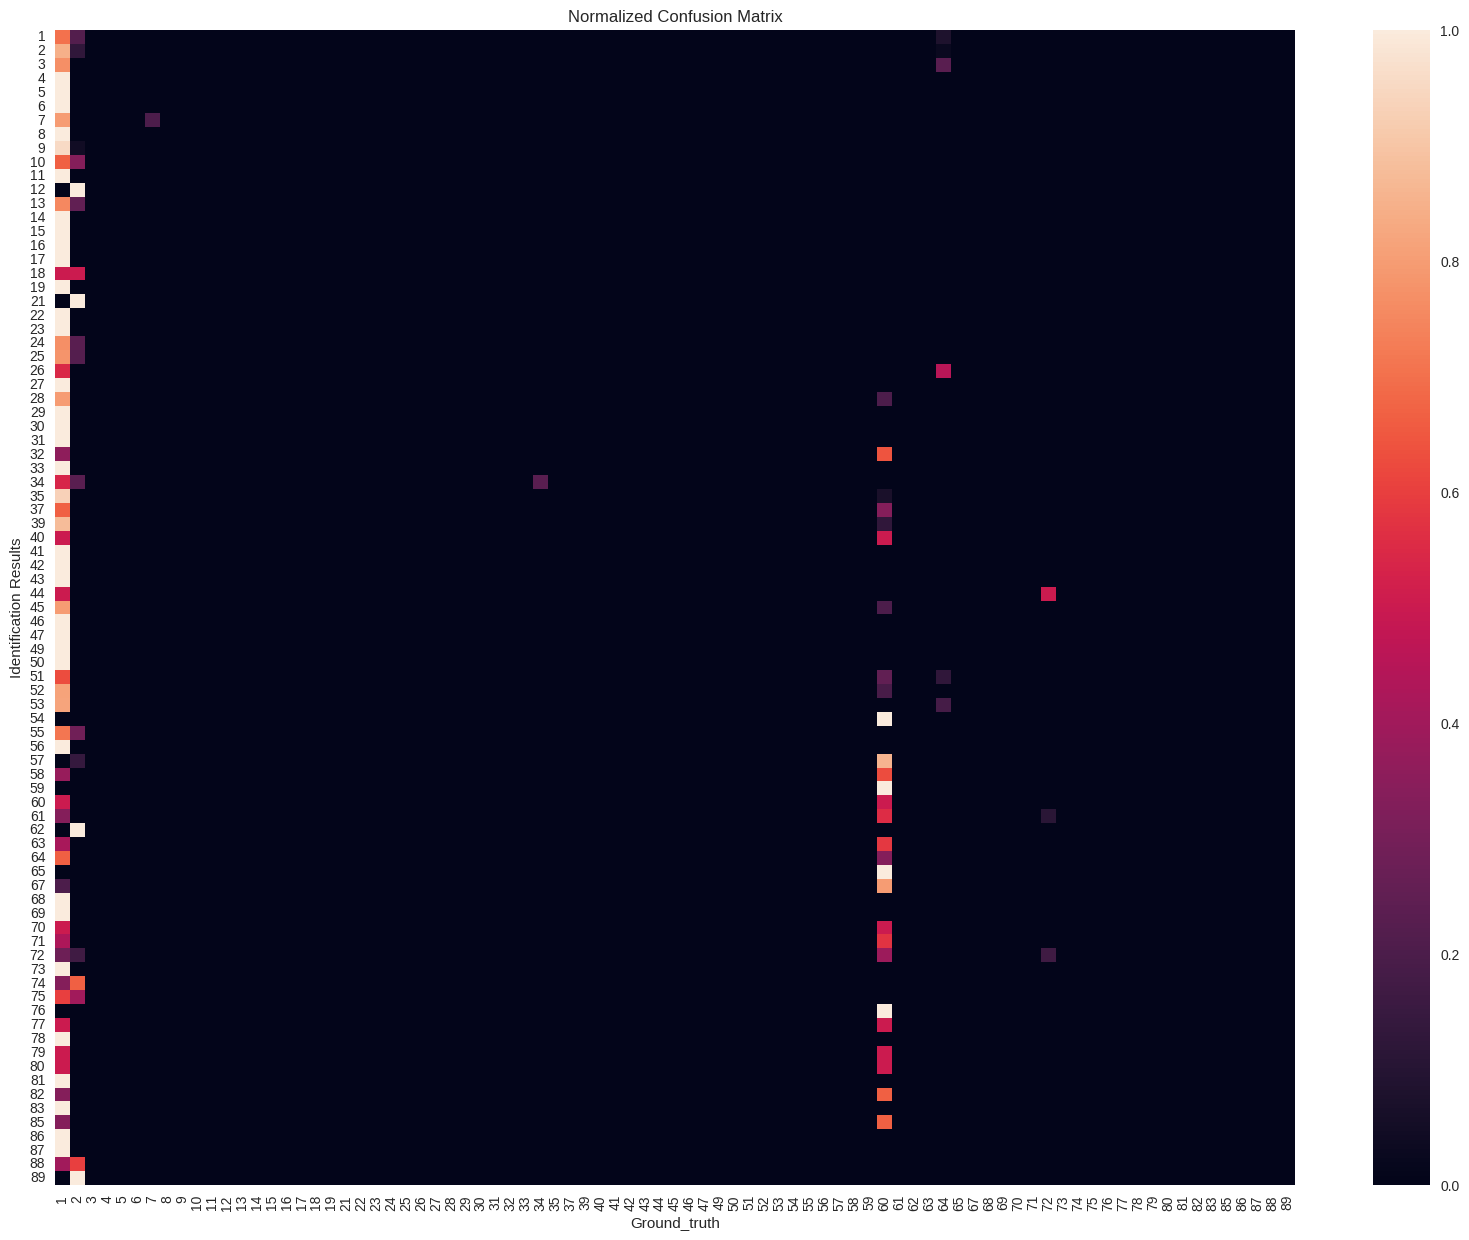

In [ ]:
# vgg19:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Ground_truth')
plt.ylabel('Identification Results')
plt.show()


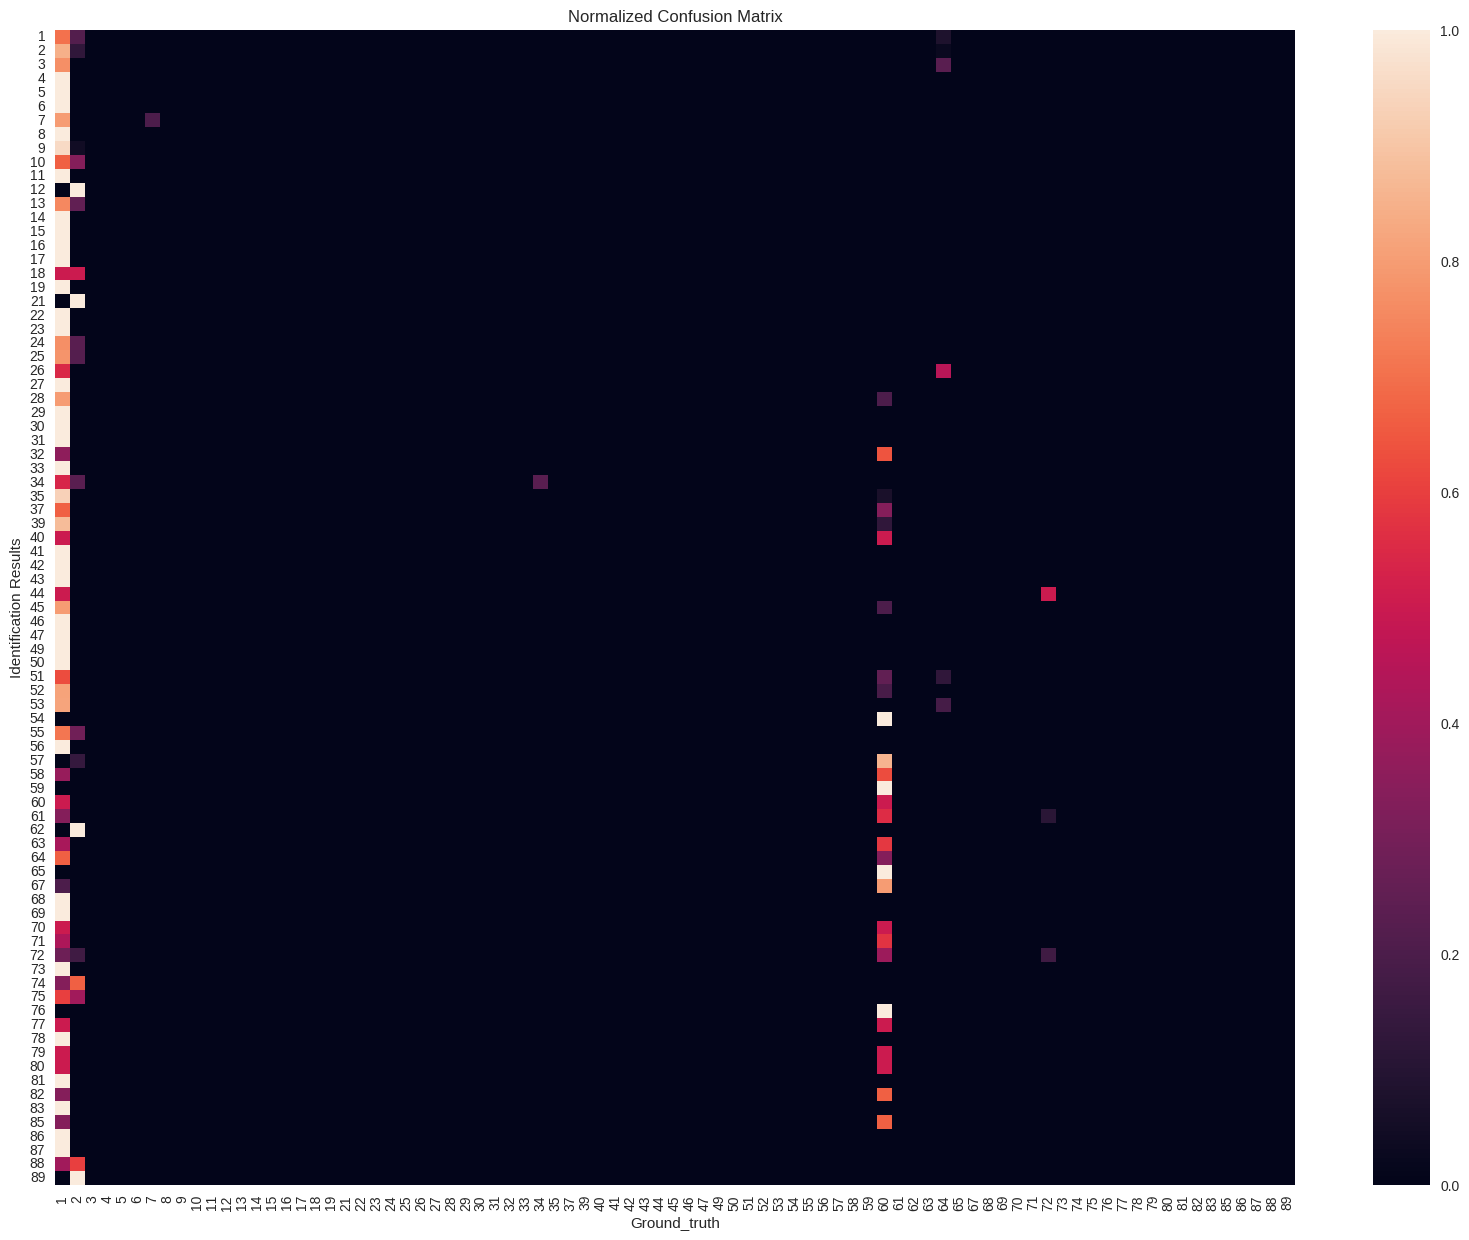

In [ ]:
#inceptionV3:

from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Ground_truth')
plt.ylabel('Identification Results')
plt.show()


#**Comparison :**

Accuracy comparison:

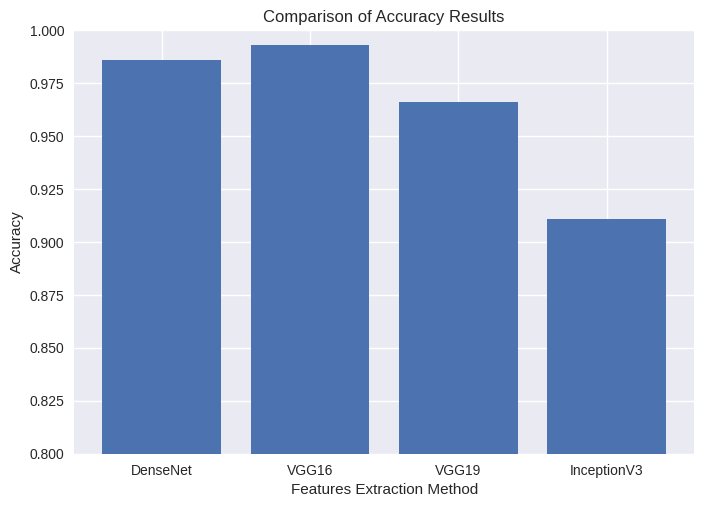

In [ ]:

import matplotlib.pyplot as plt

# Accuracy results
accuracy_densenet =0.986
accuracy_vgg16 =  0.993
accuracy_vgg19 =  0.966
accuracy_inceptionV3 = 0.911


# Create a bar plot
plt.bar(['DenseNet', 'VGG16','VGG19','InceptionV3'], [accuracy_densenet, accuracy_vgg16,accuracy_vgg19,accuracy_inceptionV3])

# Add labels and title
plt.xlabel('Features Extraction Method')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Results')

plt.ylim([0.8,1])
# Show the plot
plt.show()




Loss Comparison:

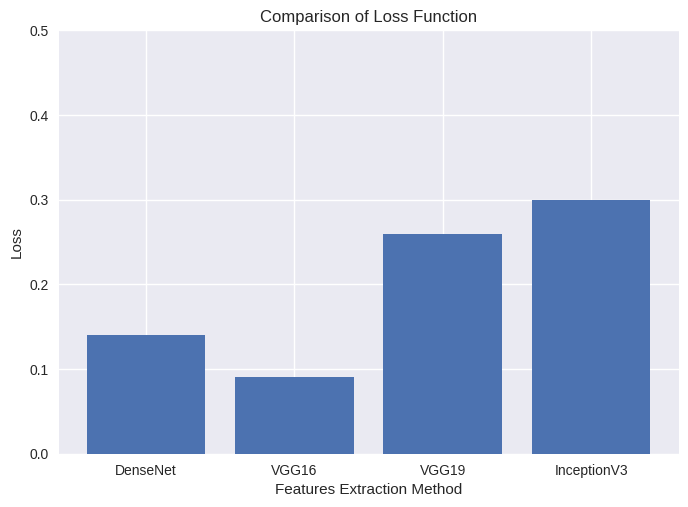

In [ ]:

import matplotlib.pyplot as plt

# Accuracy results
loss_densenet =  0.14
loss_vgg16 =   0.09
loss_vgg19 =  0.26
loss_inceptionV3 =  0.30

# Create a bar plot
plt.bar(['DenseNet', 'VGG16','VGG19','InceptionV3'], [loss_densenet, loss_vgg16,loss_vgg19,loss_inceptionV3])

# Add labels and title
plt.xlabel('Features Extraction Method')
plt.ylabel('Loss')
plt.title('Comparison of Loss Function')
plt.ylim([0,0.5])


# Show the plot
plt.show()




Time comparison

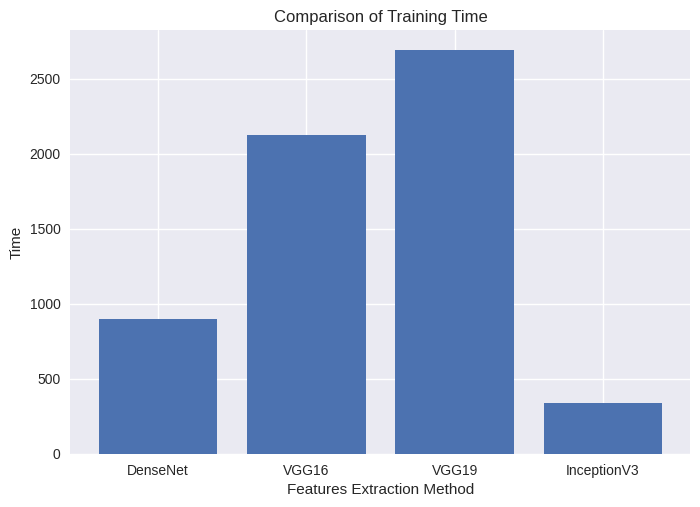

In [ ]:

import matplotlib.pyplot as plt

# time results
time_densenet =900
time_vgg16 =  2121
time_vgg19 =  2688
time_inceptionV3 = 340

# Create a bar plot
plt.bar(['DenseNet', 'VGG16','VGG19','InceptionV3'], [time_densenet, time_vgg16,time_vgg19,time_inceptionV3])

# Add labels and title
plt.xlabel('Features Extraction Method')
plt.ylabel('Time')
plt.title('Comparison of Training Time')


# Show the plot
plt.show()


